# Example 6 - Scattered Data and 'Heat Maps'

There are different ways to map point data to a smooth field. One way is to triangulate the data, smooth it and interpolate to a regular mesh (see previous notebooks). It is also possible to construct weighted averages from scattered points to a regular mesh. In this notebook we work through how to find where points lie in the mesh and map their values to nearby vertices. 

## Notebook contents

   - [Scattered data](#Point-data-with-uneven-spatial-distribution)
   - [Computational mesh](#Define-a-regular-computational-mesh)
   - [Data count by triangle](#Count-heat-flow-points-per-triangle)
   - [Data count by nearest vertex](#Count-earthquakes-per-vertex)
   - [Distance weighting to vertices](#Inverse-distance-weighted-number-of-earthquakes)
   
   
The next example is [Ex7-Refinement-of-Triangulations](./Ex7-Refinement-of-Triangulations.md)

## Point data with uneven spatial distribution

Define a relatively smooth function that we can interpolate from the coarse mesh to the fine mesh and analyse. At local scales it is convenient to use projected coordinate reference systems (CRS) to work in metres instead of degrees. We use the heat flow database for Southeastern Australia from [Mather _et al._ 2017](https://doi.org/10.1016/j.tecto.2017.12.015)

In [1]:
import numpy as np

HFdata = np.loadtxt("../Data/HeatFlowSEAustralia.csv", delimiter=',', usecols=(3,4,5), skiprows=1)

eastings  = HFdata[:,0]
northings = HFdata[:,1]
heat_flow = HFdata[:,2]

/Users/runner/miniconda3/envs/conda-build-docs/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


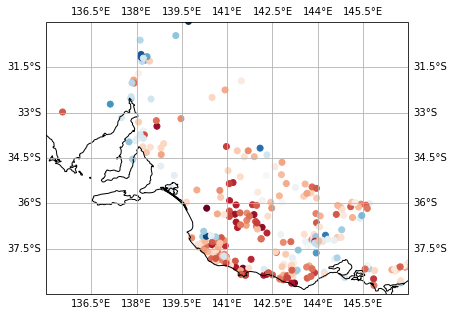

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

# local coordinate reference system
proj = ccrs.epsg(28354)


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.set_extent([135, 147, -39, -30])

ax.scatter(eastings, northings,
           marker="o", cmap=plt.cm.RdBu, c=heat_flow, transform=proj)

ax.gridlines(draw_labels=True)
plt.show()

## Define a regular computational mesh

Use the (usual) icosahedron with face points included.

In [3]:
import stripy as stripy

xmin = eastings.min()
xmax = eastings.max()
ymin = northings.min()
ymax = northings.max()
extent = [xmin, xmax, ymin, ymax]

# define a mesh with 20km x 20km resolution
spacingX = 10000.0
spacingY = 10000.0

mesh = stripy.cartesian_meshes.square_mesh(extent, spacingX, spacingY, refinement_levels=0, tree=True)

print("number of points = {}".format(mesh.npoints))

number of points = 45920


## Count heat flow points per triangle 

This is a numpy wrapper around the `TRIPACK` routine which operates by retriangulation and is therefore not particularly fast.

In [4]:
triangles = mesh.containing_triangle(eastings, northings)

In [5]:
## The return_counts argument is quite new in numpy

try:
    tris, counts = np.unique(triangles, return_counts=True)
except:

    def unique_count(a):
        unique, inverse = np.unique(a, return_inverse=True)
        count = np.zeros(len(unique), np.int)
        np.add.at(count, inverse, 1)
        return unique, count

    tris, counts = unique_count(triangles)
    
print("number of unique triangles = {}".format(tris.shape[0]))

number of unique triangles = 271


In [6]:
## map to nodes so we can plot this

hit_count = np.zeros(mesh.npoints)

for i in range(0, tris.shape[0]):
    hit_count[mesh.simplices[tris[i]]] += counts[i]

hit_count /= 3.0

print("mean number of hits = {}".format(hit_count.mean()))

mean number of hits = 0.0064024390243902435


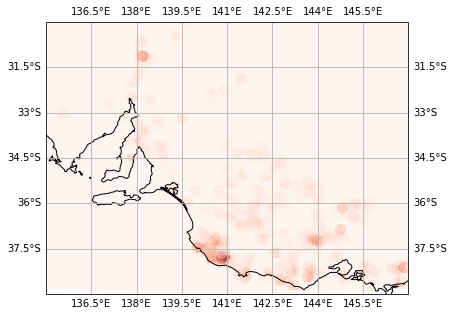

In [7]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.set_extent([135, 147, -39, -30])

ax.scatter(mesh.x, mesh.y,
           marker="o", cmap=plt.cm.Reds, s=100, c=hit_count, alpha=0.33, transform=proj)

ax.gridlines(draw_labels=True)
plt.show()

## Count points per vertex

The `Triangulation.nearest_vertices` method uses a k-d tree to find the nearest vertices to a set of x,y points. It returns the nearest vertices and euclidean distance. This requires the k-d tree to have been built when the mesh was initialised (`tree=True`)

In [8]:
distances, vertices = mesh.nearest_vertices(eastings, northings, k=1)
nodes, ncounts = np.unique(vertices, return_counts=True)

hit_countn = np.zeros(mesh.npoints)
hit_countn[nodes] = ncounts

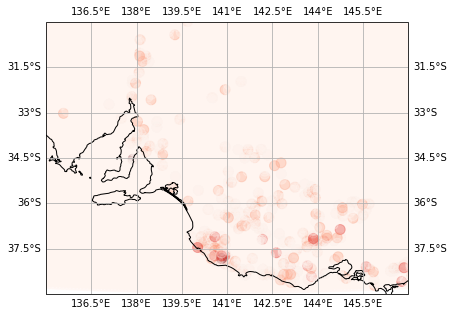

In [9]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.set_extent([135, 147, -39, -30])

ax.scatter(mesh.x, mesh.y,
           marker="o", cmap=plt.cm.Reds, s=100, c=hit_countn, alpha=0.33, transform=proj)

ax.gridlines(draw_labels=True)
plt.show()

## Inverse distance weighted number of measurement points

The k-d tree method provides a specified number of neighbours and the distance to those neighbours. This can be used in a number of ways to smooth or amalgamate data. Here for example is a weighted average of each earthquake to nearby nodes. 

We compute the distances to $N$ nearby vertices and distribute information to those vertices in inverse proportion to their distance.

$$ w _i = \frac{d _i}{\sum_{i=1}^N d _i} $$

Alternatively, we might map information to the vertices by applying a radially symmetric kernel to the point data without normalising.

In [10]:
distances, vertices = mesh.nearest_vertices(eastings, northings, k=100)
norm = distances.sum(axis=1)

# distances, vertices are arrays of shape (data_size, 10)

hit_countid = np.zeros(mesh.npoints)

## numpy shouldn't try to vectorise this reduction operation

for i in range(0,distances.shape[0]):
    hit_countid[vertices[i,:]] += distances[i,:] / norm[i]


hit_countidr = np.zeros(mesh.npoints)

## numpy shouldn't try to vectorise this reduction operation

for i in range(0,distances.shape[0]):
    hit_countidr[vertices[i,:]] += np.exp( -distances[i,:] / 0.02 ) 


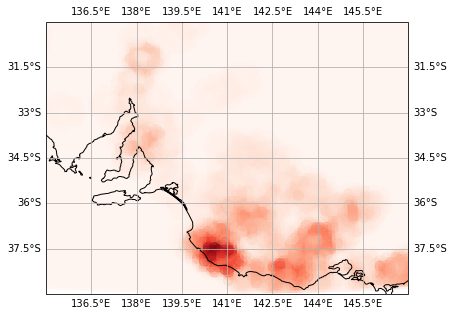

In [11]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.set_extent([135, 147, -39, -30])

ax.scatter(mesh.x, mesh.y,
           marker="o", cmap=plt.cm.Reds, s=100, c=hit_countid, alpha=0.33, transform=proj)

ax.gridlines(draw_labels=True)
plt.show()

The next example is [Ex7-Refinement-of-Triangulations](./Ex7-Refinement-of-Triangulations.md)